# Исследование мобильного приложения

В нашем распоряжении логи мобильного приложения стартапа, который продает продукты питания, за время проведения A/A/B-эксперимента. 

Нам нужно провести исследование поведения пользователей и результатов эксперимента. 

## Изучение данных из файла

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.2f}".format)
import warnings
warnings.simplefilter('ignore')

In [2]:
# чтение файла с данными и сохранение в df
df = pd.read_csv('../../yandex-praktikum-sources/logs_exp.csv', sep='\t')

In [3]:
display(df.head())
display(df.info())
print(f'Количество дубликатов {df.duplicated().sum()}')

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Количество дубликатов 413


In [4]:
print(df.ExpId.unique())
print(df.EventName.unique())

[246 248 247]
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


Файл содержит информацию о 244126 событиях. Согласно документации к данным:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Время события сохранено в секундах, заголовки столбцов не совсем удобны, заметное количество дубликатов. Исправим это.

## Подготовка данных

In [5]:
# переименование столбцов
df = df.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'event_time', 'ExpId':'group'})
# преобразование времени
df.event_time = pd.to_datetime(df.event_time, unit='s')

# создание столбца с датой
df['event_date'] = df.event_time.dt.date

# удаление дубликатов 
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
# посмотрим, что получилось
display(df.head())
display(df.info())

event_name            device_id          event_time  group  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42    248   

   event_date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

## Анализ данных 

### Распределение событий по пользователям

In [7]:
print(f'Всего в логе осталось {len(df)} событий.')
print(f'Всего пользователей в логе {len(df.device_id.unique())}.')
print(f'В среднем на пользователя приходится {int(len(df) / len(df.device_id.unique()))} события.')
df.groupby('device_id')[['event_name']].count().describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])

Всего в логе осталось 243713 событий.
Всего пользователей в логе 7551.
В среднем на пользователя приходится 32 события.


event_name
count     7551.00
mean        32.28
std         65.15
min          1.00
5%           3.00
25%          9.00
50%         20.00
75%         37.00
95%         89.00
99%        200.50
max       2307.00

В среднем, на каждого пользователя приходится 32 события. Медианное количество при этом составляет 20, и всего у одного процента пользователей  количество событий переваливает за 200. 

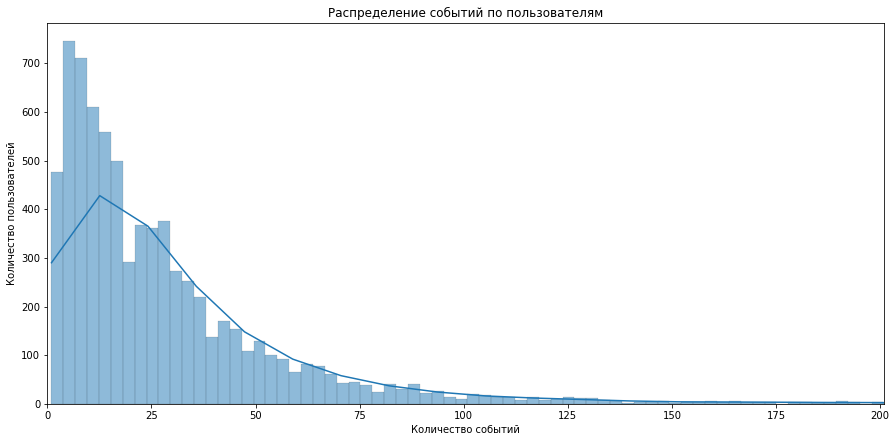

In [8]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df.groupby('device_id')[['event_name']].count(), x='event_name', kde=True)
plt.title('Распределение событий по пользователям')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.xlim(0,201)
plt.show()

Оценим, 32 события на пользователя - много ли это? Кажется, что не очень. Посмотрим, по сколько раз пользователи заходят в приложение - соберем события по людям и датам, считая, что за день - только одна сессия.

In [9]:
users_dates = df.groupby(['device_id', 'event_date'])['event_name'].count().reset_index()
# количество событий за сессию
users_dates.event_name.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])

count   27226.00
mean        8.95
std        22.98
min         1.00
5%          1.00
25%         3.00
50%         5.00
75%        10.00
95%        24.00
99%        51.00
max      2190.00
Name: event_name, dtype: float64

Получается, в среднем на сессию приходится 5 событий. При четырех основных этапов - главная, каталог, корзина, оплата - это логично, например, после оплаты вернуться на главную автоматически. Некоторые листают приложение дольше.

Посмотрим, по сколько сессий приходится на человека

In [10]:
print(users_dates.groupby('device_id')['event_date'].count().describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]))

count   7551.00
mean       3.61
std        1.95
min        1.00
5%         1.00
25%        2.00
50%        3.00
75%        5.00
95%        7.00
99%        8.00
max        9.00
Name: event_date, dtype: float64


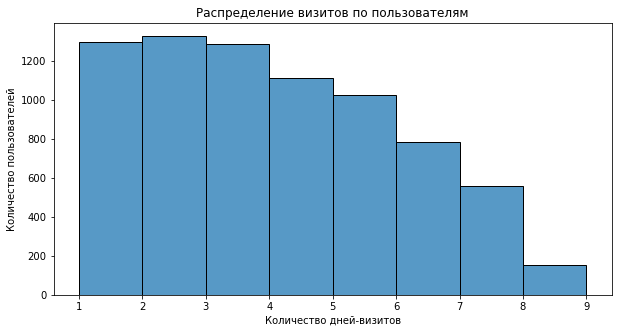

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(data=users_dates.groupby('device_id')[['event_date']].count(), x='event_date', bins=8)
plt.title('Распределение визитов по пользователям')
plt.xlabel('Количество дней-визитов')
plt.ylabel('Количество пользователей')
plt.show()

То есть медианный пользователь 3 раза за две недели зашел в приложение и тыкнул на 5 страничек. 32 события в таком случае довольно много, но кто-то из пользователей и по 9 раз зашел, и 2190 раз тыкнул (интересно, зачем). В целом, число 32 реалистичное. 

### Распределение логов по времени

Проверим, данными за какой преиод мы располагаем и как они распределены.

In [12]:
print(df.event_time.min())
print(df.event_time.max())

2019-07-25 04:43:36
2019-08-07 21:15:17


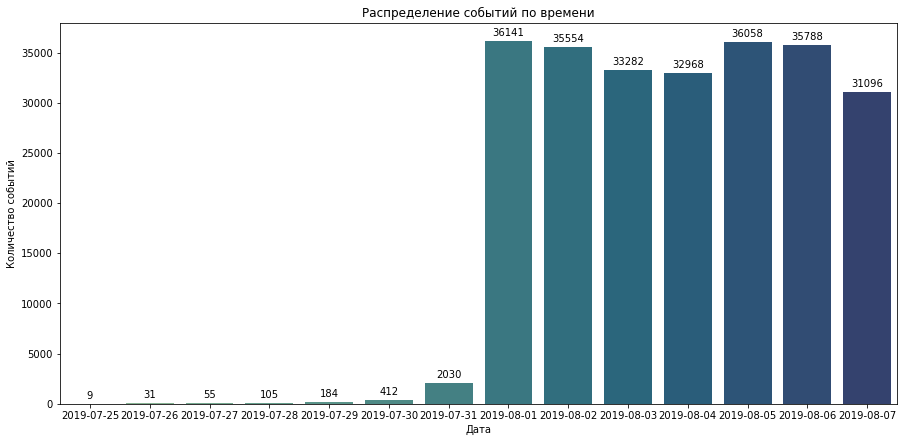

In [13]:
series = df.groupby('event_date')[['event_name']].count().reset_index()

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='event_date', y='event_name', data=series, palette='crest')
for i, v in series.iterrows():
       ax.text(i, v[1]+500, str(v[1]), ha='center')
plt.title('Распределение событий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

В имеющихся данных информация за две недели - с 25 июля по 7 августа 2019 года. 

1 августа происходит резкий скачок количества событий - с двух тысяч до 36. Скорее всего, во вторую неделю проходила рекламная кампания, которая так повлияла на данные. Следует считать данные первой недели устаревшими. Отфильтруем их.

In [14]:
# отфильтровываем данные по дате
df_2w = df.query('event_date >= datetime(2019, 8, 1).date()')
print(df_2w.info())
print()
print(f'{(len(df_2w) / len(df)):.2%} - доля событий второй недели')
print(f'Всего пользователей во второй неделе {len(df_2w.device_id.unique())}.')
print()
print(df_2w.groupby('group')['device_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   event_date  240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB
None

98.84% - доля событий второй недели
Всего пользователей во второй неделе 7534.

group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


Таким образом, во вторую неделю попадет почти 99% лога и 7534 из 7551 пользователей. Среди них представители всех трех групп эксперимента и размеры групп примерно равны.

## Воронка событий

Изучим, какие события встречаются в логах. 

In [15]:
df_2w.event_name.unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

Событий пять:
- `MainScreenAppear` - просмотр главной страницы
- `OffersScreenAppear` - просмотр страницы предложений
- `CartScreenAppear` - просмотр корзины
- `PaymentScreenSuccessful` - переход на страницу успешной оплаты
- `Tutorial` - просмотр обучающей информации для новых пользователей

Первые четыре события образуют последовательную цепочку движения пользователя по приложению. Обучение же не является обязательным этапом (если приложение достаточно дружелюбное).

In [16]:
# сгруппируем таблицу по событиям
event_users = df_2w.groupby('event_name').agg({'device_id':'nunique'}).reset_index()
event_users.set_axis(['event_name', 'users_count'], axis='columns', inplace=True)
# добавитим столбец - какая доля уникальных пользователей совершала это событие
event_users['%'] = event_users.users_count / df_2w['device_id'].nunique()
event_users = event_users.sort_values('users_count', ascending=False).reset_index(drop=True)

# построим воронку
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'users_count'] /  (event_users.loc[i-1, 'users_count'])

event_users

event_name  users_count    %  funnel
0         MainScreenAppear         7419 0.98    1.00
1       OffersScreenAppear         4593 0.61    0.62
2         CartScreenAppear         3734 0.50    0.81
3  PaymentScreenSuccessful         3539 0.47    0.95
4                 Tutorial          840 0.11    1.00

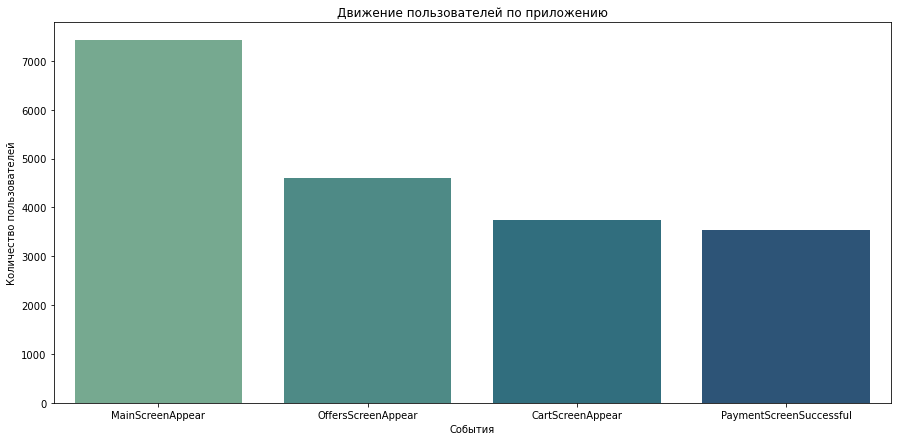

In [17]:
plt.figure(figsize=(15, 7))
sns.barplot(data=event_users.loc[0:3], x='event_name', y='users_count', palette='crest')
plt.title('Движение пользователей по приложению')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show()

Даже первый шаг воронки проходит не 100% пользователей - получается, на главную страницу заходить не обязательно. 

Самый большой скачок посещаемости - между главной страницей и страницей предложений (каталогом) - почти 40% пользователей туда не приходят. Зато на следующих шагах отсеивается всего 19% и 5% пользователей соответветственно. 

Всего до успешной оплаты доходят 47% пользователей приложения. 

## Анализ результатов эксперимента

Для анализа возьмем актуальные данные - за вторую неделю. 

### Проведение А/А теста

In [18]:
print(df_2w.groupby('group')['device_id'].nunique())

group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


Всего имеются три группы пользователей: группы 246 и 247 - контрольные, группа 248 - экспериментальная. В них соответственно по 2484, 2513 и 2537 человек. 

**Критерии успешного A/A теста:**
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. 

In [19]:
# разница в количестве пользователей
for i in range(0, 3):
    gr_list = [246, 247, 248, 246]
    print(f'Разница между группой {gr_list[i]} и {gr_list[i+1]} составляет {1 - df_2w.query("group == @gr_list[@i]")["device_id"].nunique() / df_2w.query("group == @gr_list[@i+1]")["device_id"].nunique():.2%}')


Разница между группой 246 и 247 составляет 1.15%
Разница между группой 247 и 248 составляет 0.95%
Разница между группой 248 и 246 составляет -2.13%


Количество пользователей в каждой из групп достаточно большое для проведения исследования и разница между размерами групп незначительная. 

Проверить, как зафиксированы и отправлены логи, мы не можем - остается положиться на источник наших данных.

In [20]:
# распределение пользователей по группам
len(df_2w.groupby('device_id')['group'].nunique().reset_index().query('group > 1'))

0

Среди пользователей нет попавших в несколько групп. 

Остается проверить различие ключевых метрик. Для каждого события подсчитаем, какая доля пользователей в каждой группе его совершила, и проверим, является ли отличие между группами статистически достоверным.

In [21]:
# разделим пользователей по группам и событиям
events_groups = df_2w.pivot_table(index='event_name', columns='group', values='device_id', aggfunc='nunique', margins=True).reset_index().sort_values('All', ascending=False).reset_index(drop=True)
events_groups = events_groups.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
events_groups

group               event_name   246   247   248   All
0             MainScreenAppear  2450  2476  2493  7419
1           OffersScreenAppear  1542  1520  1531  4593
2             CartScreenAppear  1266  1238  1230  3734
3      PaymentScreenSuccessful  1200  1158  1181  3539
4                     Tutorial   278   283   279   840
5                          All  2484  2513  2537  7534

In [22]:
# функция для проверки различий
# то же самое можно сделать встроенной функцией бибилиотеки, но в данном проекте предлагалось написать ее самостоятельно

def check_stats(successes1, successes2, trials1, trials2):
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / (p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) ** 0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [23]:
# создадим пустой датафрейм для записи результатов
groups_stats = pd.DataFrame({'events' : ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
                             '246-247' : [0, 0, 0, 0, 0],
                             '247-248' : [0, 0, 0, 0, 0],
                             '248-246' : [0, 0, 0, 0, 0]})

# пройдемся циклом по всем событиям и по всем парам групп
# для каждой пары групп и для каждого события посчитаем вероятности получения таких различий
for i in range(0, 5):
    for j in range(1, 4):
        # для группы 248 парной должна побывать и 246
        k = j + 1 if j < 3 else 1
        # общее количество пользователей в группе в пятой строке All
        groups_stats.iloc[i, j] = check_stats(events_groups.iloc[i, j], 
                                              events_groups.iloc[i, k], 
                                              events_groups.iloc[5, j], 
                                              events_groups.iloc[5, k])

# посмотрим, что получилось
groups_stats.iloc[:, [0, 1]].style.highlight_min(color='darkorange', axis=None)

Для всех событий разница в пропорциях недостаточна, чтобы говорить о статистически значимом различии. То есть между группами 246 и 247 разницы нет.

### Проведение А/B теста

Ранее мы посчитали статистические показатели для групп 246, 247 в сравнении с группой 248. Посмотрим на результаты.

**Гипотеза H0**: между долями нет значимой разницы <br>
**Гипотеза H1**: между долями есть значимая разница

In [24]:
groups_stats.iloc[:, [0, 2, 3]].style.highlight_min(color='darkorange', axis=None)

Добавим в таблицу `events_group` столбец для объединенной группы 246+246 и сравним ее с экспериментальной группой.

In [25]:
# создаем столбец данных для объединенной группы
events_groups['246+247'] = events_groups[246] + events_groups[247]
events_groups

group               event_name   246   247   248   All  246+247
0             MainScreenAppear  2450  2476  2493  7419     4926
1           OffersScreenAppear  1542  1520  1531  4593     3062
2             CartScreenAppear  1266  1238  1230  3734     2504
3      PaymentScreenSuccessful  1200  1158  1181  3539     2358
4                     Tutorial   278   283   279   840      561
5                          All  2484  2513  2537  7534     4997

In [26]:
# создаем столбец со статистическими показателяим
groups_stats['246+247-248'] = 1

# заполняем новый столбец
for i in range(0, 5):
    groups_stats.iloc[i, 4] = check_stats(events_groups.iloc[i, 3], 
                                        events_groups.iloc[i, 5], 
                                        events_groups.iloc[5, 3], 
                                        events_groups.iloc[5, 5])

In [27]:
groups_stats.style.highlight_min(color='darkorange', axis=None)

Так как в нашем эксперименте 4 пары групп и 4 этапа в воронке, число гипотез равно 16, и используя поправку Бонферрони, значение p-value следовало бы уменьшить до 0,003.

Однако, для всех событий и всех пар групп p-value значительно больше 0.05 - минимальное значение 0,078.

Следовательно, нулевую гипотезу не удалось отвергнуть, и шрифт не влияет на взаимодействие пользователя с приложением. 

## Выводы 

В ходе исследования мы изучили данные о работе мобильного приложения-магазина. 

Данные были получены в ходе проведения эксперимента. Нулевой гипотезой было предположение, что выбранный дизайнерами шрифт не влияет на взаимодействие пользователей с приложением. Отвергнуть эту гипотезу не удалось, по-видимому, шрифт действительно не влияет на пользователей, либо новый шрифт так же удобен и читаем, как старый. 

Наибольший скачок в воронке наблюдается между начальной страницей приложения и каталогом - этот этап не проходят почти 40% пользователей. Возможно, следует поискать проблему в этом этапе. 